In [1]:
# # Reformat code for Jupyter Notebook:
# %load_ext nb_black

# # Reformat code for Jupyter Lab:
%load_ext lab_black

<img src="medias/Brown_Logo.png" style="height:100px; float: right;">

# 🐢 Faster code workshop 🐌

<hr style="border-top: 1px solid #d8232a;">

<!-- <video width="320" height="240" autoplay loop style="float: right;">
  <source src="../data/medias/bip-bip.webp" type="video/webp">
</video>
 -->

###### Andrea PIERRÉ
###### January 20, 2021
###### Fleischmann Lab &mdash; Brown University

# Outline
1. Classic Python vs. NumPy
2. DataFrames...
3. Numba
4. Code profiling 🔎


> “We should forget about small efficiencies, say about 97% of the time: **premature optimization is the root of all evil**. Yet we should not pass up our opportunities in that critical 3%.”
> 
> — Donald Knuth


<img src="medias/one-does-not-simply.jpeg" style="display: block;
  margin-left: auto;
  margin-right: auto;">

<img src="medias/Python-logo.png" style="height:100px; float: right;">

# Classic Python

In [2]:
def loop(array_length):
    array = range(1, int(array_length))
    x = []
    for idx, item in enumerate(array):
        x.append(item + 1)
        if x[idx] > 5:
            x[idx] -= 1
    return x

<img src="medias/numpy.png" style="height:100px; float: right;">

# With NumPy

In [3]:
import numpy as np


def loop_np(array_length):
    array = np.arange(1, array_length)
    x = array + 1
    x[x > 5] -= 1
    return x

# Python vs. NumPy

In [4]:
%timeit loop(10)
%timeit loop_np(10)

1.25 µs ± 113 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3.55 µs ± 345 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [5]:
%timeit loop(1000000)
%timeit loop_np(1000000)

156 ms ± 3.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.6 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
array_length = [10, 10e2, 10e3, 10e4, 10e5, 10e6]
timep = []
timenp = []
for item in array_length:
    varp = %timeit -o loop(item)
    varnp = %timeit -o loop_np(item)
    timep.append(varp.average)
    timenp.append(varnp.average)

1.21 µs ± 15.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
3.48 µs ± 99.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
140 µs ± 2.13 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
7.43 µs ± 105 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
1.5 ms ± 46.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
31.2 µs ± 183 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
16 ms ± 99.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
290 µs ± 8.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
166 ms ± 2.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.4 ms ± 522 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.64 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
109 ms ± 7.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


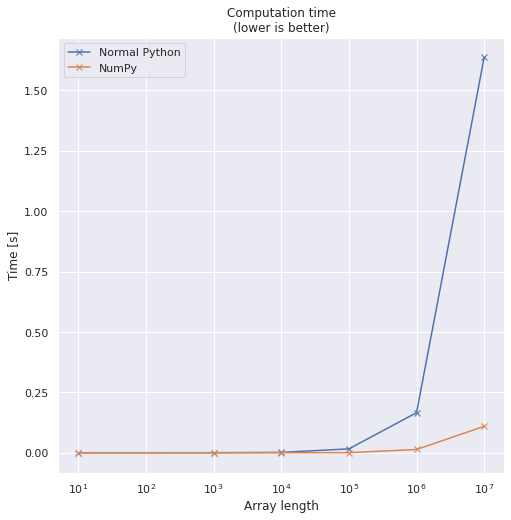

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(array_length, timep, "-x", label="Normal Python")
ax.plot(array_length, timenp, "-x", label="NumPy")
ax.semilogx()
ax.set_xlabel("Array length")
ax.set_ylabel("Time [s]")
ax.set_title("Computation time\n(lower is better)")
ax.legend(loc="best")
plt.show()

# Pandas

In [8]:
import numpy as np
import pandas as pd

array_length = 10
index = pd.date_range("2021-01-15T08:00:00", periods=array_length, freq="min")
rng = np.random.default_rng()
odors = np.arange(1, 10)
odors_vect = rng.choice(odors, array_length, replace=True)
df = pd.DataFrame(odors_vect, index=index, columns=["odors"])
df

odors
2021-01-15 08:00:00      1
2021-01-15 08:01:00      8
2021-01-15 08:02:00      1
2021-01-15 08:03:00      7
2021-01-15 08:04:00      1
2021-01-15 08:05:00      7
2021-01-15 08:06:00      5
2021-01-15 08:07:00      2
2021-01-15 08:08:00      2
2021-01-15 08:09:00      3

In [9]:
df["processed"] = [idx for idx, _ in enumerate(df.index)]
df["processed"] = df["processed"].apply(lambda x: pd.NA if x % 2 else x)
df.processed = df.odors[df.processed.isna()]
df

odors  processed
2021-01-15 08:00:00      1        NaN
2021-01-15 08:01:00      8        8.0
2021-01-15 08:02:00      1        NaN
2021-01-15 08:03:00      7        7.0
2021-01-15 08:04:00      1        NaN
2021-01-15 08:05:00      7        7.0
2021-01-15 08:06:00      5        NaN
2021-01-15 08:07:00      2        2.0
2021-01-15 08:08:00      2        NaN
2021-01-15 08:09:00      3        3.0

In [10]:
count_df = df.groupby(by="odors").count()
count_df

processed
odors           
1              0
2              1
3              1
5              0
7              2
8              1

In [11]:
import numpy as np
import pandas as pd


def calc_pd(array_length):
    index = pd.date_range("2021-01-15T08:00:00", periods=array_length, freq="min")
    rng = np.random.default_rng()
    odors = np.arange(1, 10)
    odors_vect = rng.choice(odors, array_length, replace=True)
    df = pd.DataFrame(odors_vect, index=index, columns=["odors"])
    df["processed"] = [idx for idx, _ in enumerate(df.index)]
    df["processed"] = df["processed"].apply(lambda x: pd.NA if x % 2 else x)
    df.processed = df.odors[df.processed.isna()]
    count_df = df.groupby(by="odors").count()
    return count_df

# DataFrames: Pandas vs. Modin


> Modin: Scale your pandas workflow by changing a single line of code

<img src="medias/pandas_multicore.png" style="height:400px; float: left;">
<img src="medias/modin_multicore.png" style="height:400px; float: right;">

In [12]:
# import os
# os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
# # os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

# We'll import Modin this way:
import modin.pandas as md

# But the selling point of Modin is that it uses that same API/methods/functions as Pandas
# so we could just import it this way and use the same Pandas code we already have:
# import modin.pandas as pd

In [13]:
def calc_md(array_length):
    index = md.date_range("2021-01-15T08:00:00", periods=array_length, freq="min")
    rng = np.random.default_rng()
    odors = np.arange(1, 10)
    odors_vect = rng.choice(odors, array_length, replace=True)
    df = md.DataFrame(odors_vect, index=index, columns=["odors"])
    df["processed"] = [idx for idx, _ in enumerate(df.index)]
    df["processed"] = df["processed"].apply(lambda x: md.NA if x % 2 else x)
    df.processed = df.odors[df.processed.isna()]
    count_df = df.groupby(by="odors").count()
    return count_df

In [14]:
%timeit calc_pd(1000000)
%timeit calc_md(1000000)

1.04 s ± 19 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


(pid=13094) UserWarning: The pandas version installed 1.1.4 does not match the supported pandas version in Modin 1.1.5. This may cause undesired side effects!
(pid=13089) UserWarning: The pandas version installed 1.1.4 does not match the supported pandas version in Modin 1.1.5. This may cause undesired side effects!
(pid=13096) UserWarning: The pandas version installed 1.1.4 does not match the supported pandas version in Modin 1.1.5. This may cause undesired side effects!
(pid=13091) UserWarning: The pandas version installed 1.1.4 does not match the supported pandas version in Modin 1.1.5. This may cause undesired side effects!
(pid=13090) UserWarning: The pandas version installed 1.1.4 does not match the supported pandas version in Modin 1.1.5. This may cause undesired side effects!
(pid=13097) UserWarning: The pandas version installed 1.1.4 does not match the supported pandas version in Modin 1.1.5. This may cause undesired side effects!
(pid=13092) UserWarning: The pandas version in

2.12 s ± 41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Couldn't get faster results with Modin compared to Pandas... 🧐

<img src="medias/fail.gif" style="display: block;
  margin-left: auto;
  margin-right: auto;">


<img src="medias/numba.png" style="height:100px; float: right;">

# Numba


In [15]:
import time
from numba import jit


@jit
def square(x):
    return x ** 2


# DO NOT REPORT THIS... COMPILATION TIME IS INCLUDED IN THE EXECUTION TIME!
start = time.time()
square(5)
end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

# NOW THE FUNCTION IS COMPILED, RE-TIME IT EXECUTING FROM CACHE
start = time.time()
square(5)
end = time.time()
print("Elapsed (after compilation) = %s" % (end - start))

Elapsed (with compilation) = 0.20019316673278809
Elapsed (after compilation) = 4.172325134277344e-05


In [16]:
from numba import jit

array_length = 10

%timeit loop(array_length)
%timeit loop_np(array_length)
%timeit jit(loop)(array_length)
%timeit jit(loop_np)(array_length)

1.32 µs ± 52.9 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
4.94 µs ± 115 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
96.8 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
199 ms ± 9.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
from numba import jit

array_length = 10000000

%timeit loop(array_length)
%timeit loop_np(array_length)
%timeit jit(loop)(array_length)
%timeit jit(loop_np)(array_length)

1.71 s ± 9.31 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
180 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
489 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
362 ms ± 12.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
array_length = [10, 10e2, 10e3, 10e4, 10e5, 10e6]
timep = []
timenp = []
timejit = []
timenpjit = []
for item in array_length:
    varp = %timeit -o loop(item)
    varnp = %timeit -o loop_np(item)

    # We run the functions once before timing them to remove the compilation time
    jit(loop)(item)
    jit(loop_np)(item)
    varjit = %timeit -o jit(loop)(item)
    varnpjit = %timeit -o jit(loop_np)(item)

    timep.append(varp.average)
    timenp.append(varnp.average)
    timejit.append(varjit.average)
    timenpjit.append(varnpjit.average)

1.35 µs ± 64.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
5.01 µs ± 199 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
99.3 ms ± 3.92 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
206 ms ± 12.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
153 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
8.38 µs ± 186 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
110 ms ± 16.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
197 ms ± 10.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.59 ms ± 10.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
34.9 µs ± 1.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
97.3 ms ± 2.27 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
203 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
15.9 ms ± 241 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
404 µs ± 100 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each

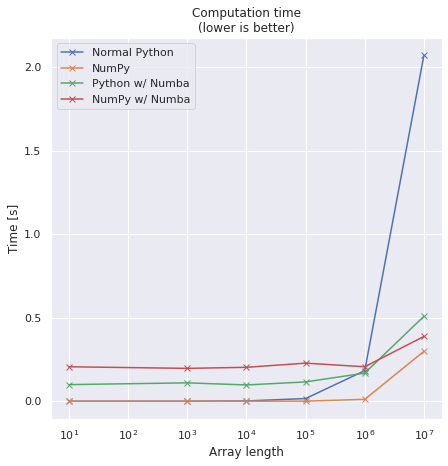

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(array_length, timep, "-x", label="Normal Python")
ax.plot(array_length, timenp, "-x", label="NumPy")
ax.plot(array_length, timejit, "-x", label="Python w/ Numba")
ax.plot(array_length, timenpjit, "-x", label="NumPy w/ Numba")
ax.semilogx()
ax.set_xlabel("Array length")
ax.set_ylabel("Time [s]")
ax.set_title("Computation time\n(lower is better)")
ax.legend(loc="best")
plt.show()

## What to compile with Numba ?

The general recommendation is that you should only try to compile the **critical paths** in your code.
<!-- If you have a piece of performance-critical computational code amongst some higher-level code, you may factor out the performance-critical code in a separate function and compile the separate function with Numba. -->
Letting Numba focus on that small piece of performance-critical code has several advantages:

- it reduces the risk of hitting unsupported features;
- it reduces the compilation times;
- **it allows you to evolve the higher-level code which is outside of the compiled function much easier.**


# Code profiling 🔎

In [20]:
%load_ext snakeviz

%snakeviz loop(10)
%snakeviz loop_np(10)

 
*** Profile stats marshalled to file '/tmp/tmp67hpkku1'. 
Embedding SnakeViz in this document...


 
*** Profile stats marshalled to file '/tmp/tmpm65wi603'. 
Embedding SnakeViz in this document...


In [21]:
%snakeviz calc_pd(10)
%snakeviz calc_md(10)

 
*** Profile stats marshalled to file '/tmp/tmp9tm4l55n'. 
Embedding SnakeViz in this document...


 
*** Profile stats marshalled to file '/tmp/tmp_8osk9th'. 
Embedding SnakeViz in this document...


# Many other solutions
- Cython
- NumExpr
- Pythran
- PyPy
- Dask
- JAX
- ...